In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import pykeen
import matplotlib.pyplot as plt
import torch
from pykeen.datasets import Nations, WN18RR
from pykeen.pipeline import pipeline
from pykeen import predict
import pandas as pd

from pykeen.datasets import PathDataset


from utils import prepare_for_visualization

/home/albert/anaconda3/envs/kg-workshop-23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-12 21:58:57.742095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 21:58:58.960609: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [4]:
WN18RR_PATH = Path("data/WN18RR/text")

In [5]:
wn18rr = PathDataset(
    WN18RR_PATH / "train.tsv",
    WN18RR_PATH / "test.tsv",
    WN18RR_PATH / "valid.tsv",
)

In [6]:
result = pipeline(
    dataset=wn18rr,
    model="TransE",
    model_kwargs={"embedding_dim": 32},
    loss="nssa",
    loss_kwargs={"adversarial_temperature": 0.34, "margin": 9},
    optimizer="Adam",
    optimizer_kwargs={"lr": 0.004},
    # training_loop=training_loop,
    # training_loop_kwargs=None,
    # negative_sampler=config["negative_sampler"],
    negative_sampler_kwargs={"num_negs_per_pos": 33},
    training_kwargs=dict(
        num_epochs=50,
        batch_size=512,
        use_tqdm_batch=False,
    ),
    # evaluator=RankBasedEvaluator,
    # evaluator_kwargs=evaluator_kwargs,
    # evaluation_kwargs=evaluation_kwargs,
    # result_tracker=result_tracker,
    # evaluation_fallback=True,
    random_seed=123,
)

You're trying to map triples with 213 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 211 from 3134 triples were filtered out
You're trying to map triples with 218 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 217 from 3034 triples were filtered out
No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:15<00:00,  5.12s/epoch, loss=0.139, prev_loss=0.139]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|███████████████████████████████████

In [7]:
save_location = "results"  # this directory
result.save_to_directory(save_location)
os.listdir(save_location)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=40714, num_relations=11, create_inverse_triples=False, num_triples=86835, path="/home/albert/dev/pwr/kg-workshop-23/data/WN18RR/text/train.tsv") to file:///home/albert/dev/pwr/kg-workshop-23/results/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/albert/dev/pwr/kg-workshop-23/results


['trained_model.pkl', 'results.json', 'training_triples', 'metadata.json']

In [8]:
# How to look at the model
model = result.model
model

TransE(
  (loss): NSSALoss()
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(40714, 32)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(11, 32)
    )
  )
  (weight_regularizers): ModuleList()
)

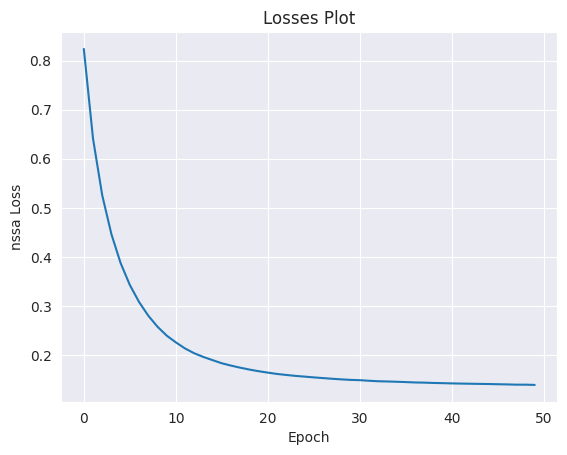

In [9]:
result.plot_losses()
plt.show()

In [16]:
metrics = result.metric_results.to_df()
metrics[(metrics.Side == "both") & (metrics.Type == "realistic")]

,Side,Type,Metric,Value
5,both,realistic,z_geometric_mean_rank,76.35409
14,both,realistic,z_inverse_harmonic_mean_rank,2214.67634
23,both,realistic,count,5846.00000
32,both,realistic,adjusted_geometric_mean_rank_index,0.99776
41,both,realistic,adjusted_inverse_harmonic_mean_rank,0.18402
50,both,realistic,inverse_geometric_mean_rank,0.02899
59,both,realistic,median_absolute_deviation,14.82602
68,both,realistic,adjusted_arithmetic_mean_rank_index,0.90824
77,both,realistic,variance,34128136.00000
86,both,realistic,geometric_mean_rank,34.49302


In [12]:
result.model.entity_representations

ModuleList(
  (0): Embedding(
    (_embeddings): Embedding(40714, 32)
  )
)

In [18]:
embeddings = result.model.entity_representations[0](torch.arange(wn18rr.num_entities))
labels = [wn18rr.training.entity_id_to_label[i] for i in range(wn18rr.num_entities)]

In [19]:
prepare_for_visualization(embeddings.detach().numpy(), labels, Path("logs/wn18rr"))